This code largely follows the work of github user purnasi at https://github.com/purnasai/Dino_V2/blob/main/2.PCA_visualization.ipynb .

In [97]:
# Imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

In [98]:
IMG_SIZE: int = 518
RESIZE_DIM: int = IMG_SIZE + 2
PATCH_SIZE: int = 14
FEAT_DIM: int = 384 # for vits
PATCH_W: int = IMG_SIZE // PATCH_SIZE
PATCH_H: int = IMG_SIZE // PATCH_SIZE

transform = transforms.Compose([           
    transforms.Resize(RESIZE_DIM),
    transforms.CenterCrop(IMG_SIZE),            
    transforms.ToTensor(),                    
    transforms.Normalize(mean=0.5, std=0.2)
])

unnormalize = transforms.Normalize(
    mean=-0.5 / 0.2,
    std=1 / 0.2
)

to_img = transforms.ToPILImage()

Load model here. Add '_lc' to load the ImageNet 1k linear classifier version, but we just want the features.

In [99]:
dinov2_vits14: nn.Module  = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14.eval()
dinov2_vits14.cuda()
pass # here to flush stdout

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [100]:
def get_img_features(img_tensor: torch.Tensor, model: Any) -> np.ndarray:
    # feed (processed) img tensor into DINOV2, get the features and detach
    features_dict = model.forward_features(img_tensor.unsqueeze(0))
    features = features_dict["x_norm_patchtokens"]
    return features.detach().cpu().numpy()

In [101]:
def normalise_pca(pca: np.ndarray) -> np.ndarray:
    # normalize each component of the pca individually
    out = np.zeros_like(pca)
    n_components: int = pca.shape[-1]
    for i in range(n_components):
        c = pca[:, i]
        amax, amin = np.amax(c), np.amin(c)
        out[:, i] = (c - amin) / (amax - amin)
    return out

In [102]:
class PlotParams(TypedDict): # little helper class for typed plotting
    colour: str
    title: str

plane_params: PlotParams = {'colour': 'C0', 'title': 'Plane'}
sketch_params: PlotParams = {'colour': 'C1', 'title': 'Sketch'}
sofc_params: PlotParams = {'colour': 'C2', 'title': 'SOFC'}

plot_params: List[PlotParams] = [plane_params, sketch_params, sofc_params]

In [109]:
def load_image(path: str, transform: transforms.Compose) -> Tuple[torch.tensor, Image.Image]:
    # Load image with PIL, convert to tensor by applying $transform, and invert transform to get display image
    image = Image.open(path).convert("RGB")
    tensor = transform(image)
    transformed_img = to_img(unnormalize(tensor))
    return tensor, transformed_img

def get_pca_features(feat_arr: np.ndarray, n_patches_h: int, n_patches_w: int, feat_dim: int, n_components:int =3) -> np.ndarray:
    #  Take np array output of DINOv2 and compute $n_components principal components.
    reshaped_features: np.ndarray = feat_arr.reshape(n_patches_h * n_patches_w, feat_dim)
    pca = PCA(n_components=n_components)
    pca.fit(reshaped_features)
    pca_features = pca.transform(reshaped_features)
    return pca_features

def plot_pca_hists(pcas: List[np.ndarray], plot_params: List[PlotParams], n_components: int=3, show_first: bool=True) -> None:
    # Loop through each of the pcas, plot an image of the pcas and the distributions of the first 3 components.
    n_imgs = len(pcas)
    n_plots = n_components + 1 if show_first is True else n_components
    fig, axs = plt.subplots(n_imgs, n_plots)
    fig.set_size_inches(12, 4)
    fig.tight_layout()
    for i in range(n_imgs):
        params = plot_params[i]
        for j in range(n_plots):
            ax: plt.axes.Axes = axs[i, j] if n_imgs > 1 else axs[j]
            if j == 0 and show_first: # draw first component spatially
                normed = normalise_pca(pcas[i])
                ax.set_title(params['title'])
                ax.imshow(normed[:, :].reshape(PATCH_H, PATCH_W, 3))
                ax.set_axis_off()
            else: # plot hist
                component = pcas[i][:, j - 1]
                ax.hist(component, bins=20, color=params['colour'])
                if i == 0:
                    ax.set_title(f"PCA Component {j}")

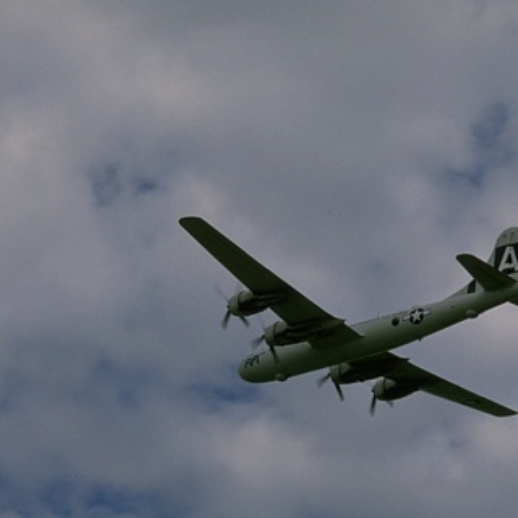

In [104]:
plane_tensor, plane_img = load_image("plane.jpg", transform)
plane_tensor = plane_tensor.to('cuda')

sofc_tensor, sofc_img = load_image("sofc.png", transform)
sofc_tensor = sofc_tensor.to('cuda')

sketch_tensor, sketch_img = load_image("sketch.jpg", transform)
sketch_tensor = sketch_tensor.to('cuda')
plane_img

In [105]:
pcas: List[np.ndarray] = []

for tensor in [plane_tensor, sketch_tensor, sofc_tensor]:
    dino_features_arr = get_img_features(tensor, dinov2_vits14)
    pca_features_arr = get_pca_features(dino_features_arr, PATCH_H, PATCH_W, FEAT_DIM)
    pcas.append(pca_features_arr)

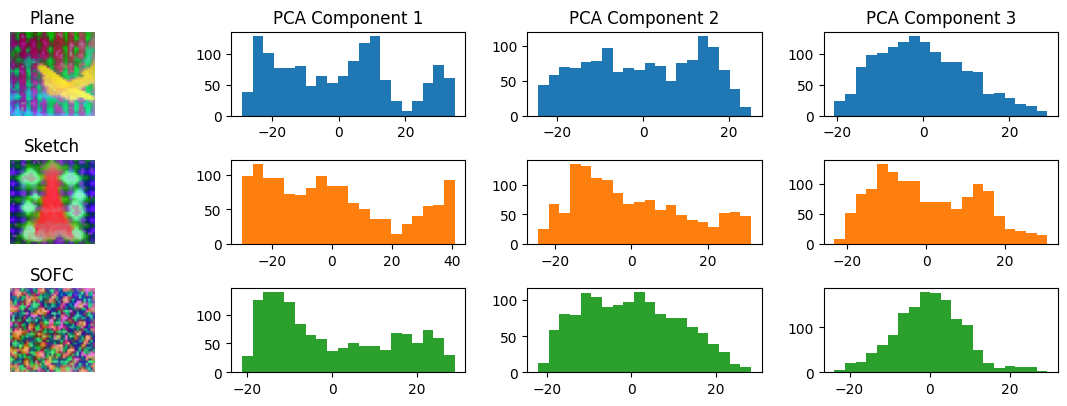

In [110]:
plot_pca_hists(pcas, plot_params)

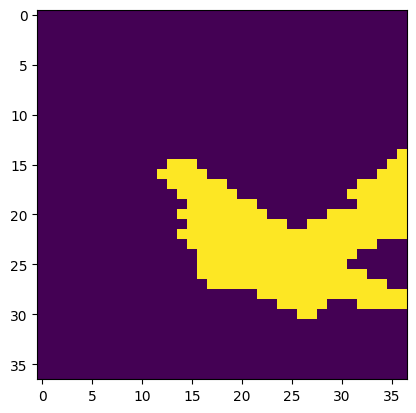

In [107]:
FG_THRESHOLD = 20 # from histograms
fg = pcas[0][:, 0] > FG_THRESHOLD
plt.imshow(fg.reshape(PATCH_H, PATCH_W))